In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import random
from tqdm import tqdm
sns.set()
import matplotlib.pyplot as plt

# Data

In [2]:
wmt_toen = pickle.load(open('./wmt_toen_bleurt.pkl', 'rb'))
wmt_toen.head(1)

,system,sid,raw_score,score,N,lp,reference,source,output,year,system_full,bleurt
0,online-B,1673,63.0,-0.00167,2,cs-en,Ten statements by Albert Einstein that enriche...,"Desatero výroků Alberta Einsteina, které oboha...",Ten Commandments statements of Albert Einstein...,2016,NaN,-0.167327


# Validation

Official BLEURT segment-level results:
https://github.com/google-research/bleurt/blob/master/README.md#overview

In [3]:
wmt_toen[wmt_toen.year == 2019].groupby('lp')[['bleurt', 'score']].corr('kendall')[['bleurt']][1::2].T

lp,fi-en,gu-en,kk-en,lt-en,ru-en
,score,score,score,score,score
bleurt,0.31354,0.281363,0.395622,0.353805,0.283788


# Plots

### Raw correlations

##### Test set

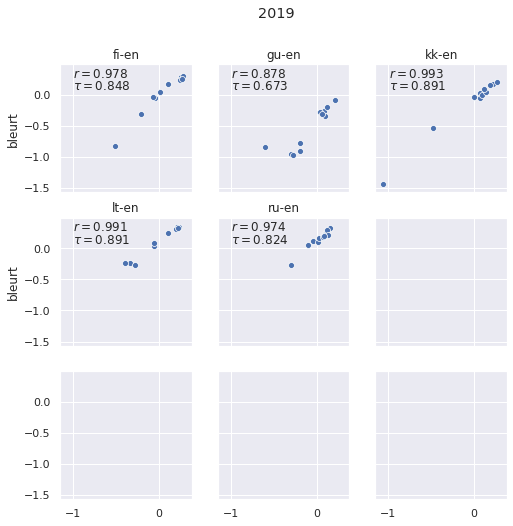

In [4]:
f, axes = plt.subplots(3, 3, figsize=(8,8), sharex=True, sharey=True)
wmt2019_toen = wmt_toen[wmt_toen.year == 2019]
f.suptitle('2019')

for coord, (i, group) in zip(itertools.product([0,1,2], [0,1,2]), wmt2019_toen.groupby('lp')):
    system_level = group.groupby('system').mean()
    r = system_level.corr('pearson')['bleurt']['score']
    tau = system_level.corr('kendall')['bleurt']['score']
    
    ax = axes[coord]
    ax.set_title(i)
    ax.text(0.1, 0.9, '$r=%.3f$' % r, fontsize=12, transform=ax.transAxes)
    ax.text(0.1, 0.8, '$\\tau=%.3f$' % tau, fontsize=12, transform=ax.transAxes)
    sns.scatterplot(data=system_level, x='score', y='bleurt', ax=ax)

##### Train set

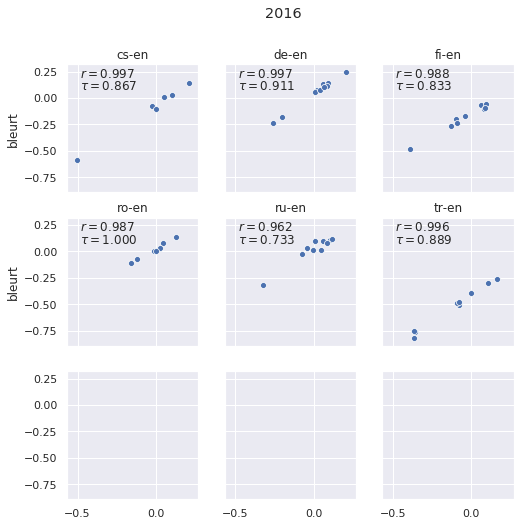

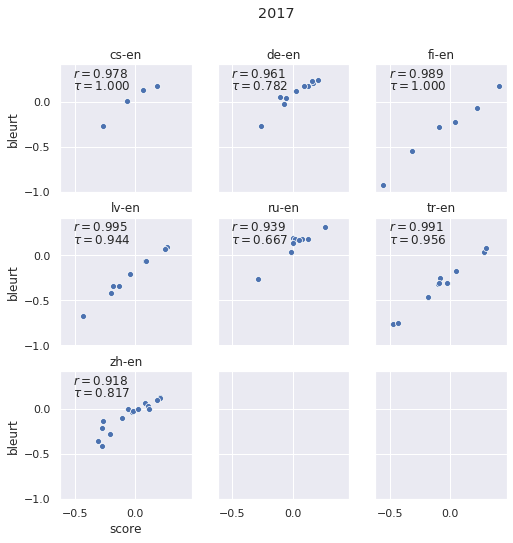

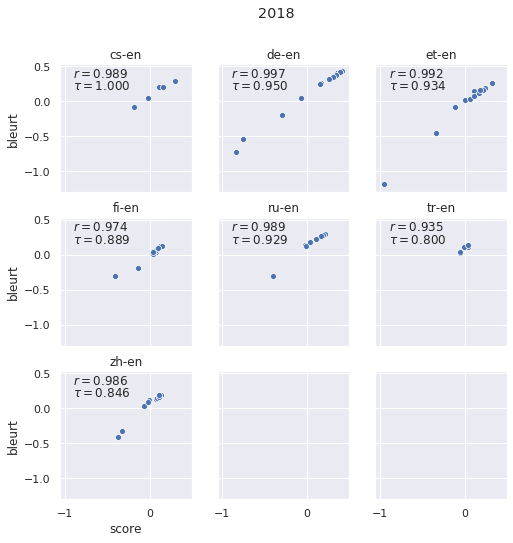

In [5]:
for year, group in wmt_toen.groupby('year'):
    if year == 2019:
        continue
        
    f, axes = plt.subplots(3, 3, figsize=(8,8), sharex=True, sharey=True)
    toen = wmt_toen[wmt_toen.year == year]
    f.suptitle(str(year))

    for coord, (i, group) in zip(itertools.product([0,1,2], [0,1,2]), toen.groupby('lp')):
        system_level = group.groupby('system').mean()
        r = system_level.corr('pearson')['bleurt']['score']
        tau = system_level.corr('kendall')['bleurt']['score']

        ax = axes[coord]
        ax.set_title(i)
        ax.text(0.1, 0.9, '$r=%.3f$' % r, fontsize=12, transform=ax.transAxes)
        ax.text(0.1, 0.8, '$\\tau=%.3f$' % tau, fontsize=12, transform=ax.transAxes)
        sns.scatterplot(data=system_level, x='score', y='bleurt', ax=ax)

### Considering statistical significance

In [8]:
import multiprocessing
pool = multiprocessing.Pool(8)

def f(i):
    subset, s1, s2, human_statistic, metric_statistic = i
    
    subset['labels'] = random.sample(subset['system'].tolist(), len(subset))
    ra_scores = subset.groupby('labels').mean()
    
    return (np.abs(ra_scores['score'][s1] - ra_scores['score'][s2]) > np.abs(human_statistic), \
            np.abs(ra_scores['bleurt'][s1] - ra_scores['bleurt'][s2]) > np.abs(metric_statistic))

In [9]:
trials = 1000
randomized_approx = []

for (year, lp), group in wmt_toen.groupby(['year', 'lp']):
    print(year, lp)
    
    systems = list(group.system.unique())
    pairs = list(itertools.combinations(systems, 2))
    
    for s1, s2 in tqdm(pairs, total=len(pairs)):
        if s1 == s2:
            continue
            
        subset = group[(group.system == s1) | (group.system == s2)].copy()
        scores = subset.groupby('system').mean()
        human_statistic = scores['score'][s1] - scores['score'][s2]
        metric_statistic = scores['bleurt'][s1] - scores['bleurt'][s2]
        
        # pooled randomized approximation
        results = pool.map(f, [(subset, s1, s2, human_statistic, metric_statistic)] * trials)
        human_c, metric_c = sum(i[0] for i in results), sum(i[1] for i in results)
        
        randomized_approx.append((year, lp, s1, s2, human_statistic, metric_statistic, human_c, metric_c))

  0%|          | 0/15 [00:00<?, ?it/s]

2016 cs-en


  0%|          | 0/45 [00:00<?, ?it/s]

2016 de-en


  0%|          | 0/36 [00:00<?, ?it/s]

2016 fi-en


  0%|          | 0/21 [00:00<?, ?it/s]

2016 ro-en


  0%|          | 0/45 [00:00<?, ?it/s]

2016 ru-en


  0%|          | 0/36 [00:00<?, ?it/s]

2016 tr-en


  0%|          | 0/6 [00:00<?, ?it/s]

2017 cs-en


  0%|          | 0/55 [00:00<?, ?it/s]

2017 de-en


  0%|          | 0/15 [00:00<?, ?it/s]

2017 fi-en


  0%|          | 0/36 [00:00<?, ?it/s]

2017 lv-en


  0%|          | 0/36 [00:00<?, ?it/s]

2017 ru-en


  0%|          | 0/45 [00:00<?, ?it/s]

2017 tr-en


  0%|          | 0/120 [00:00<?, ?it/s]

2017 zh-en


  0%|          | 0/10 [00:00<?, ?it/s]

2018 cs-en


  0%|          | 0/120 [00:00<?, ?it/s]

2018 de-en


  0%|          | 0/91 [00:00<?, ?it/s]

2018 et-en


  0%|          | 0/36 [00:00<?, ?it/s]

2018 fi-en


  0%|          | 0/28 [00:00<?, ?it/s]

2018 ru-en


  0%|          | 0/10 [00:00<?, ?it/s]

2018 tr-en


  0%|          | 0/91 [00:00<?, ?it/s]

2018 zh-en


  0%|          | 0/66 [00:00<?, ?it/s]

2019 fi-en


  0%|          | 0/55 [00:00<?, ?it/s]

2019 gu-en


  0%|          | 0/55 [00:00<?, ?it/s]

2019 kk-en


  0%|          | 0/55 [00:00<?, ?it/s]

2019 lt-en


  0%|          | 0/91 [00:00<?, ?it/s]

2019 ru-en


100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


In [10]:
randomized_approx = pd.DataFrame(randomized_approx)
randomized_approx.columns = ['year', 'lp', 's1', 's2', 'human_statistic', 'metric_statistic', 'human_c', 'metric_c']

In [11]:
alpha = 0.05
randomized_approx['human_sig'] = randomized_approx.human_c / trials < alpha
randomized_approx['metric_sig'] = randomized_approx.metric_c / trials < alpha

def f(row, s = 'human'):
    if row['%s_sig' % s]:
        if row['%s_statistic' % s] > 0:
            return 'gain'
        else:
            return 'loss'
    else:
        return 'NS'

randomized_approx['human_decision'] = randomized_approx.apply(lambda x: f(x, s='human'), axis=1)
randomized_approx['metric_decision'] = randomized_approx.apply(lambda x: f(x, s='metric'), axis=1)

randomized_approx[randomized_approx.human_c > 300].head(5)

,year,lp,s1,s2,human_statistic,metric_statistic,human_c,metric_c,human_sig,metric_sig,human_decision,metric_decision
11,2016,cs-en,PJATK,online-A,-0.024639,0.029466,313,46,False,True,NS,gain
21,2016,de-en,online-G,jhu-pbmt,-0.010159,-0.021342,637,87,False,False,NS,NS
29,2016,de-en,uedin-pbmt,jhu-pbmt,0.022356,0.001449,324,906,False,False,NS,NS
31,2016,de-en,uedin-pbmt,KIT,-0.020672,-0.051980,391,0,False,True,NS,loss
34,2016,de-en,online-B,online-A,-0.009133,-0.024695,704,32,False,True,NS,loss


##### Test set

In [12]:
# we have to be careful in saying NS = 0...
ra = randomized_approx[randomized_approx.year == 2019]

labels = ['loss', 'NS', 'gain']
heatmap = []
for i in labels:
    heatmap.append([])
    for j in labels:
        count = len(ra[(ra.human_decision == i) & (ra.metric_decision == j)])
        heatmap[-1].append(count)
heatmap = np.array(heatmap)

Text(30.5, 0.5, 'human')

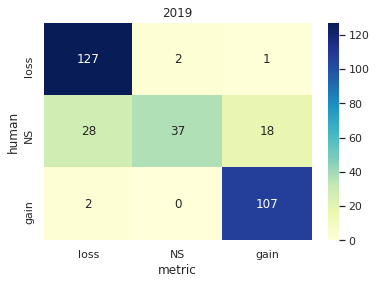

In [13]:
sns.heatmap(heatmap, cmap="YlGnBu", annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title('2019')
plt.xlabel('metric')
plt.ylabel('human')

##### Train set

In [14]:
# we have to be careful in saying NS = 0...
ra = randomized_approx[randomized_approx.year != 2019]

labels = ['loss', 'NS', 'gain']
heatmap = []
for i in labels:
    heatmap.append([])
    for j in labels:
        count = len(ra[(ra.human_decision == i) & (ra.metric_decision == j)])
        heatmap[-1].append(count)
heatmap = np.array(heatmap)

Text(30.5, 0.5, 'human')

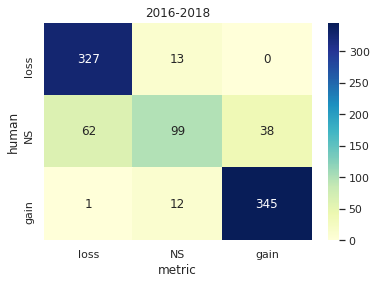

In [16]:
sns.heatmap(heatmap, cmap="YlGnBu", annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title('2016-2018')
plt.xlabel('metric')
plt.ylabel('human')

### Save results

In [ ]:
pickle.dump(randomized_approx, open(''))